In [1]:
from pypacmensl.sensitivity.multi_sinks import SensFspSolverMultiSinks
import mpi4py.MPI as mpi
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from scipy.stats import binom, poisson, norm
from scipy.special import comb     
from math import exp, log, sqrt
from matplotlib.patches import Ellipse
from numba import jit
from matplotlib.ticker import FormatStrFormatter
import ipywidgets as widgets
import seaborn as sns


sns.set(style='darkgrid')

# Constitutive gene expression model


The chemical master equation $\frac{d}{dt}\mathbf{p}(t) = \mathbf{A}\mathbf{p}(t)$

In [13]:
k_off = 0.15
k_on = 0.05
k_r = 5.0
gamma = 0.05
theta = np.array([k_off, k_on, k_r, gamma])

SM = [[-1, 1, 0], [1, -1, 0], [0, 0, 1], [0, 0, -1]]
X0 = [[1, 0, 0]]
P0 = [1.0]
S0 = [0.0]


def dprop_t_factory(i):
    def dprop_t(t, out):
        out[:] = 0.0
        out[i] = 1.0
    return dprop_t


dprop_t_list = []
for i in range(0, 4):
    dprop_t_list.append(dprop_t_factory(i))
dprop_sparsity = np.eye(4, dtype=np.intc)


def prop_t(t, out):
    out[:] = theta[:]


def prop_x(reaction, X, out):
    if reaction == 0:
        out[:] = X[:, 0]
        return None
    if reaction == 1:
        out[:] = X[:, 1]
        return None
    if reaction == 2:
        out[:] = X[:, 1]
        return None
    if reaction == 3:
        out[:] = X[:, 2]
        return None


init_bounds = np.array([1, 1, 20])


t_meas = np.linspace(0, 2*60, 121)


# Sensitivity FSP solver


In [14]:
comm = mpi.COMM_SELF
solver = SensFspSolverMultiSinks(comm)
solver.SetModel(np.array(SM), prop_t, prop_x, dprop_t_list, [prop_x] * 4, dprop_sparsity)
solver.SetVerbosity(2)
solver.SetFspShape(constr_fun=None, constr_bound=init_bounds)
solver.SetInitialDist(np.array(X0), np.array(P0), [np.array(S0)] * 4)
solutions = solver.SolveTspan(t_meas, 1.0e-4)

# Compute the RNA disribution over time and its sensitivity


In [15]:
rna_distributions = []
rna_sensitivities = []
for i in range(0, len(solutions)):
    rna_distributions.append(solutions[i].Marginal(2))
    sens_list = []
    for iS in range(0, 4):
        sens_list.append(solutions[i].SensMarginal(iS, 2))
    rna_sensitivities.append(sens_list)
        
np.savez('fsp_solutions.npz', rna_distributions=rna_distributions, rna_sensitivities=rna_sensitivities, allow_pickle=True)    

In [16]:
fsp_sol_file = np.load('fsp_solutions.npz', allow_pickle=True)
rna_distributions = fsp_sol_file['rna_distributions']
rna_sensitivities = fsp_sol_file['rna_sensitivities']
fsp_sol_file.close()

In [17]:
# FIM for exact smFISH measurements
fim_exact = np.zeros((len(t_meas), 4, 4))
for itime in range(0, len(t_meas)):
    M = np.zeros((4,4))
    for ip in range(0, 4):
        for jp in range(0, ip+1):
            M[ip, jp] = np.sum(rna_sensitivities[itime][ip]*rna_sensitivities[itime][jp]/
                               np.maximum(rna_distributions[itime], 1.0e-16))
    M = 0.5*(M.T + M)
    fim_exact[itime, : , :] = M
 
np.savez('fim_exact.npz', fim_exact=fim_exact)

# Simulate flow cytometry experiment

In [7]:
kappa = 240
mu_bg = 10
sigma_bg = 20

In [19]:
num_cells_flowcyt = 20000
intensity_samples = np.zeros((len(t_meas), num_cells_flowcyt))

for itime in range(0, len(t_meas)):
    xmax = len(rna_distributions[itime])-1
    nrna_samples = np.random.choice(xmax+1, size=(num_cells_flowcyt,), p= rna_distributions[itime]/np.sum(rna_distributions[itime]))
    bg_noise = np.random.normal(loc=mu_bg, scale=sigma_bg, size=(num_cells_flowcyt,))
    intensity_samples[itime, :] = kappa*nrna_samples + bg_noise

# Modeling measurement noise with binomial distribution

In [20]:
def BinomialNoiseMatrix(n_max, p_success):
    M = np.zeros((n_max + 1, n_max + 1))  
    for j in range(0, n_max + 1):
            M[:, j] = binom.pmf(np.linspace(0, n_max, n_max+1), j, p_success) 
    return M

n_max = 200
p_success = 0.1
C_binom = BinomialNoiseMatrix(n_max, p_success)

fim_binom = np.zeros((len(t_meas), 4, 4))
for itime in range(0, len(t_meas)):
    M = np.zeros((4,4))
    xmax = len(rna_distributions[itime])-1
    p = C_binom[0:xmax+1, 0:xmax+1]@rna_distributions[itime]
    for ip in range(0, 4):
        sip = C_binom[0:xmax+1, 0:xmax+1]@rna_sensitivities[itime][ip]
        for jp in range(0, ip+1):
            sjp = C_binom[0:xmax+1, 0:xmax+1]@rna_sensitivities[itime][jp]
            M[ip, jp] = np.sum(sip*sjp/np.maximum(1.e-16, p))
    M = 0.5*(M.T + M)
    fim_binom[itime, :, :] = M
np.savez('fim_binom.npz', fim_binom=fim_binom)


# Modeling combinatorial noise from low image resolution

In [24]:
num_pixels = 100 # number of pixels occupied by a typical cells

def LowResNoiseMatrix(n_max):
    M = np.zeros((n_max + 1, n_max + 1))  
    M[0,0] = 1.0
    for j in range(1, n_max + 1):
            M[:, j] = comb(num_pixels, np.arange(0, n_max+1))*comb(j-1, np.arange(0,n_max+1)-1)/comb(num_pixels + j - 1, j)       
    return M

n_max = 200
C_lowres = LowResNoiseMatrix(n_max)

fim_lowres = np.zeros((len(t_meas), 4, 4))
for itime in range(0, len(t_meas)):
    M = np.zeros((4,4))
    xmax = len(rna_distributions[itime])-1
    p = C_lowres[0:xmax+1, 0:xmax+1]@rna_distributions[itime]
    for ip in range(0, 4):
        sip = C_lowres[0:xmax+1, 0:xmax+1]@rna_sensitivities[itime][ip]
        for jp in range(0, ip+1):
            sjp = C_lowres[0:xmax+1, 0:xmax+1]@rna_sensitivities[itime][jp]
            M[ip, jp] = np.sum(sip*sjp/np.maximum(1.e-16, p))
    M = 0.5*(M.T + M)
    fim_lowres[itime, :, :] = M
np.savez('fim_lowres.npz', fim_lowres=fim_lowres)

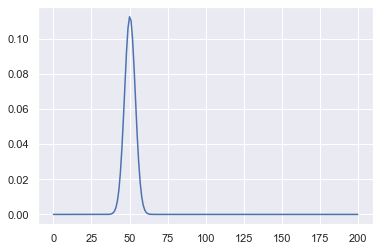

In [33]:
plt.plot(C_lowres[:,100])

In [49]:
time_slider = widgets.IntSlider(value=0, min=0, max=len(t_meas)-1, step=1, description='Time:')

def plot_rna_dist_sens(itime):
    fig_smfish = plt.figure()
    fig_smfish.set_tight_layout(True)
    gs = fig_smfish.add_gridspec(3, 2)
    xmax = len(rna_distributions[itime])-1
    p_binom = C_binom[0:xmax+1, 0:xmax+1]@rna_distributions[itime]
    p_lowres = C_lowres[0:xmax+1, 0:xmax+1]@rna_distributions[itime]
    
    fig_smfish.suptitle(f't = {t_meas[itime]:.2f}')
    ax0 = fig_smfish.add_subplot(gs[0, :])
    ax0.plot(np.arange(0, xmax+1), rna_distributions[itime], label='True')
    ax0.plot(np.arange(0, xmax+1), p_binom, color='orange', linestyle=':', label='Lossy')
    ax0.plot(np.arange(0, xmax+1), p_lowres, color='magenta', label='Low-resolution')
    ax0.set_xlabel('RNA molecule count')
    ax0.set_ylabel('Probability')
    ax0.legend()
    
    for ip in range(0,4):
        sip_binom = C_binom[0:xmax+1, 0:xmax+1]@rna_sensitivities[itime][ip]        
        sip_lowres = C_lowres[0:xmax+1, 0:xmax+1]@rna_sensitivities[itime][ip]
        ax1 = fig_smfish.add_subplot(gs[1 + ip // 2, ip % 2])
        ax1.plot(np.arange(0, xmax+1), rna_sensitivities[itime][ip])
        ax1.plot(np.arange(0, xmax+1), sip_binom, color='orange', linestyle=':')
        ax1.plot(np.arange(0, xmax+1), sip_lowres, color='magenta')
        ax1.set_xlabel('RNA molecule count')
    
    fig_flowcyt, ax = plt.subplots(1,1)
    sns.distplot(intensity_samples[itime, :], ax=ax)
    ax.set_xlabel('Intensity (AU)')
    ax.set_ylabel('Probability')
    
#     return fig_smfish, fig_flowcyt


widgets.interactive(plot_rna_dist_sens, itime=time_slider)

interactive(children=(IntSlider(value=0, description='Time:', max=120), Output()), _dom_classes=('widget-inter…

# Uncertainties in eigendirections for different experiment types with one-shot design

In [43]:
num_cells_flowcyt = 200000
num_cells_smfish = 200

with np.load('fim_exact.npz') as data:
    fim_exact = data['fim_exact']

with np.load('fim_binom.npz') as data:
    fim_binom = data['fim_binom']
    
with np.load('fim_lowres.npz') as data:
    fim_flowcyt = data['fim_lowres']    
    
with np.load('fim_flowcyt_rep0.npz') as data:
    fim_flowcyt = data['fim_flowcyt']
    
def plot_uncertainties(itime):

    [eigval, eigvec] = np.linalg.eig(num_cells_smfish*fim_exact[itime,:,:])
    uncertainties_exact = 1/np.sqrt(eigval)

    [eigval, eigvec] = np.linalg.eig(num_cells_smfish*fim_binom[itime, :, :])
    uncertainties_binom = 1/np.sqrt(eigval)
    
    [eigval, eigvec] = np.linalg.eig(num_cells_smfish*fim_lowres[itime, :, :])
    uncertainties_lowres = 1/np.sqrt(eigval)    

    [eigval, eigvec] = np.linalg.eig(num_cells_flowcyt*fim_flowcyt[itime, :, :])
    uncertainties_flowcyt = 1/np.sqrt(eigval)

    fig = plt.figure()
    fig.set_tight_layout(True)
    ax = fig.add_subplot(1,1,1)
    ax.hlines(uncertainties_exact, xmin = 1.75, xmax = 2.25, color='red', linewidth=2)
    ax.hlines(uncertainties_binom, xmin = 2.75, xmax = 3.25, color='red', linewidth=2)
    ax.hlines(uncertainties_lowres, xmin = 3.75, xmax = 4.25, color='red', linewidth=2)
    ax.hlines(uncertainties_flowcyt, xmin = 4.75, xmax = 5.25, color='red', linewidth=2)
    ax.set_yscale('log')
    ax.set_xticks([2, 3, 4, 5])
    ax.set_xticklabels([f'smFISH \n Noise-free \n {num_cells_smfish} cells', 
                        f'smFISH \n Lossy spot \n {num_cells_smfish} cells',
                        f'smFISH \n Low resolution \n {num_cells_smfish} cells',
                        f'flow cytometry \n Additive noise \n {num_cells_flowcyt} cells'])
    ax.set_ylabel('Uncertainty')
    fig.suptitle(f'One-shot experimental design \n t = {t_meas[itime]:.2f} \n')
    
time_slider = widgets.IntSlider(value=0, min=0, max=len(t_meas)-1, step=1, description='Time:')
widgets.interactive(plot_uncertainties, itime=time_slider)

interactive(children=(IntSlider(value=0, description='Time:', max=120), Output()), _dom_classes=('widget-inter…

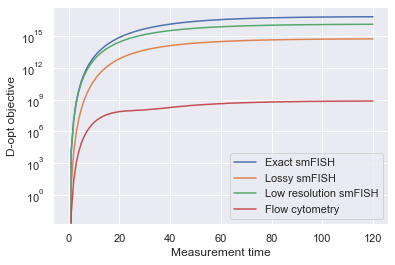

In [42]:
# Information volume across time of different measurement types
num_cells_flowcyt = 20000
num_cells_smfish = 200

with np.load('fim_exact.npz') as data:
    fim_exact = data['fim_exact']

with np.load('fim_binom.npz') as data:
    fim_binom = data['fim_binom']
    
with np.load('fim_lowres.npz') as data:
    fim_flowcyt = data['fim_lowres']     
    
with np.load('fim_flowcyt_rep0.npz') as data:
    fim_flowcyt = data['fim_flowcyt']
    
nt = fim_flowcyt.shape[0]
    
fimdet_exact = np.zeros((nt,))
fimdet_binom = np.zeros((nt,))
fimdet_lowres = np.zeros((nt,))
fimdet_flowcyt = np.zeros((nt,))

for i in range(0, nt):
    fimdet_exact[i] = np.linalg.det(num_cells_smfish*fim_exact[i,:,:])
    fimdet_binom[i] = np.linalg.det(num_cells_smfish*fim_binom[i,:,:])
    fimdet_lowres[i] = np.linalg.det(num_cells_smfish*fim_lowres[i,:,:])
    fimdet_flowcyt[i] = np.linalg.det(num_cells_flowcyt*fim_flowcyt[i,:,:])

fig, ax = plt.subplots(1,1)
ax.plot(t_meas, fimdet_exact, label='Exact smFISH')
ax.plot(t_meas, fimdet_binom, label='Lossy smFISH')
ax.plot(t_meas, fimdet_lowres, label='Low resolution smFISH')
ax.plot(t_meas, fimdet_flowcyt, label='Flow cytometry')
ax.set_yscale('log')
ax.set_ylabel('D-opt objective')
ax.set_xlabel('Measurement time')
ax.legend()